# Investigate reasons for breakpoints in the supposedly non-recombinant Nextclade subset

(This is the subset used in the cophylogeny plot)

In [1]:
import sys
import datetime
import shutil
import gzip
import tempfile
import os
import numpy as np

# install sc2ts using python -m pip install git+https://github.com/jeromekelleher/sc2ts
# where python is the python running in your jupytyer notebook (find this by
#import sys; print(sys.executable)
import tskit
import tszip
import sc2ts

# Look for most stuff in the root dir - assumes we are running within `notebooks`
sys.path.append("..")

import utils



In [2]:
ts_dir = "../data"
sc2ts_filename = "upgma-full-md-30-mm-3-2021-06-30-recinfo-gisaid-il.ts.tsz"

sc2ts_arg, basetime = utils.load_tsz(ts_dir, sc2ts_filename)

For the various rounds of simplification we use filter_nodes=False so that
we keep the smae node IDs

In [3]:

nx_fn = "nextstrain_ncov_gisaid_global_all-time_timetree-2023-01-21.nex"
with tempfile.TemporaryDirectory() as tmpdir:
    with gzip.open("../data/" + nx_fn + ".gz") as f_in:
        new_fn = os.path.join(tmpdir, nx_fn)
        with open(new_fn, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
        nextstrain_ts_tmp = sc2ts.newick_from_nextstrain_with_comments(
            sc2ts.extract_newick_from_nextstrain_nexus(new_fn),
            min_edge_length=0.0001 * 1/365,
            span=sc2ts_arg.sequence_length,
        )
        # Remove "samples" without names
        keep = [n.id for n in nextstrain_ts_tmp.nodes() if n.is_sample() and "strain" in n.metadata]
        nx_ts = nextstrain_ts_tmp.simplify(keep)

# Slow step: find the samples in sc2ts_arg.ts also in nextstrain.ts, and subset
sc2ts_its, nxstr_its = sc2ts.subset_to_intersection(
    sc2ts_arg, nx_ts, filter_sites=False, keep_unary=True, filter_nodes=False,
)


In [4]:
print("num samples in each", sc2ts_its.num_samples, nxstr_its.num_samples)

num samples in each 187 180


In [5]:
tree = sc2ts_its.first()
untouched_by_recomb = []
for sample in sc2ts_its.samples():
    u = sample
    affected_by_recomb = False
    while u != -1:
        e = sc2ts_its.edge(tree.edge(u))
        if e.left != 0 or e.right != sc2ts_its.sequence_length:
            affected_by_recomb = True
            break
        u = tree.parent(u)
    if not affected_by_recomb:
        untouched_by_recomb.append(sample)

In [6]:
keep = [s for s in sc2ts_its.samples() if s not in set(untouched_by_recomb)]
simp = sc2ts_its.simplify(keep, keep_unary=True, filter_nodes=False)
print(simp.num_trees, simp.num_samples)

8 29


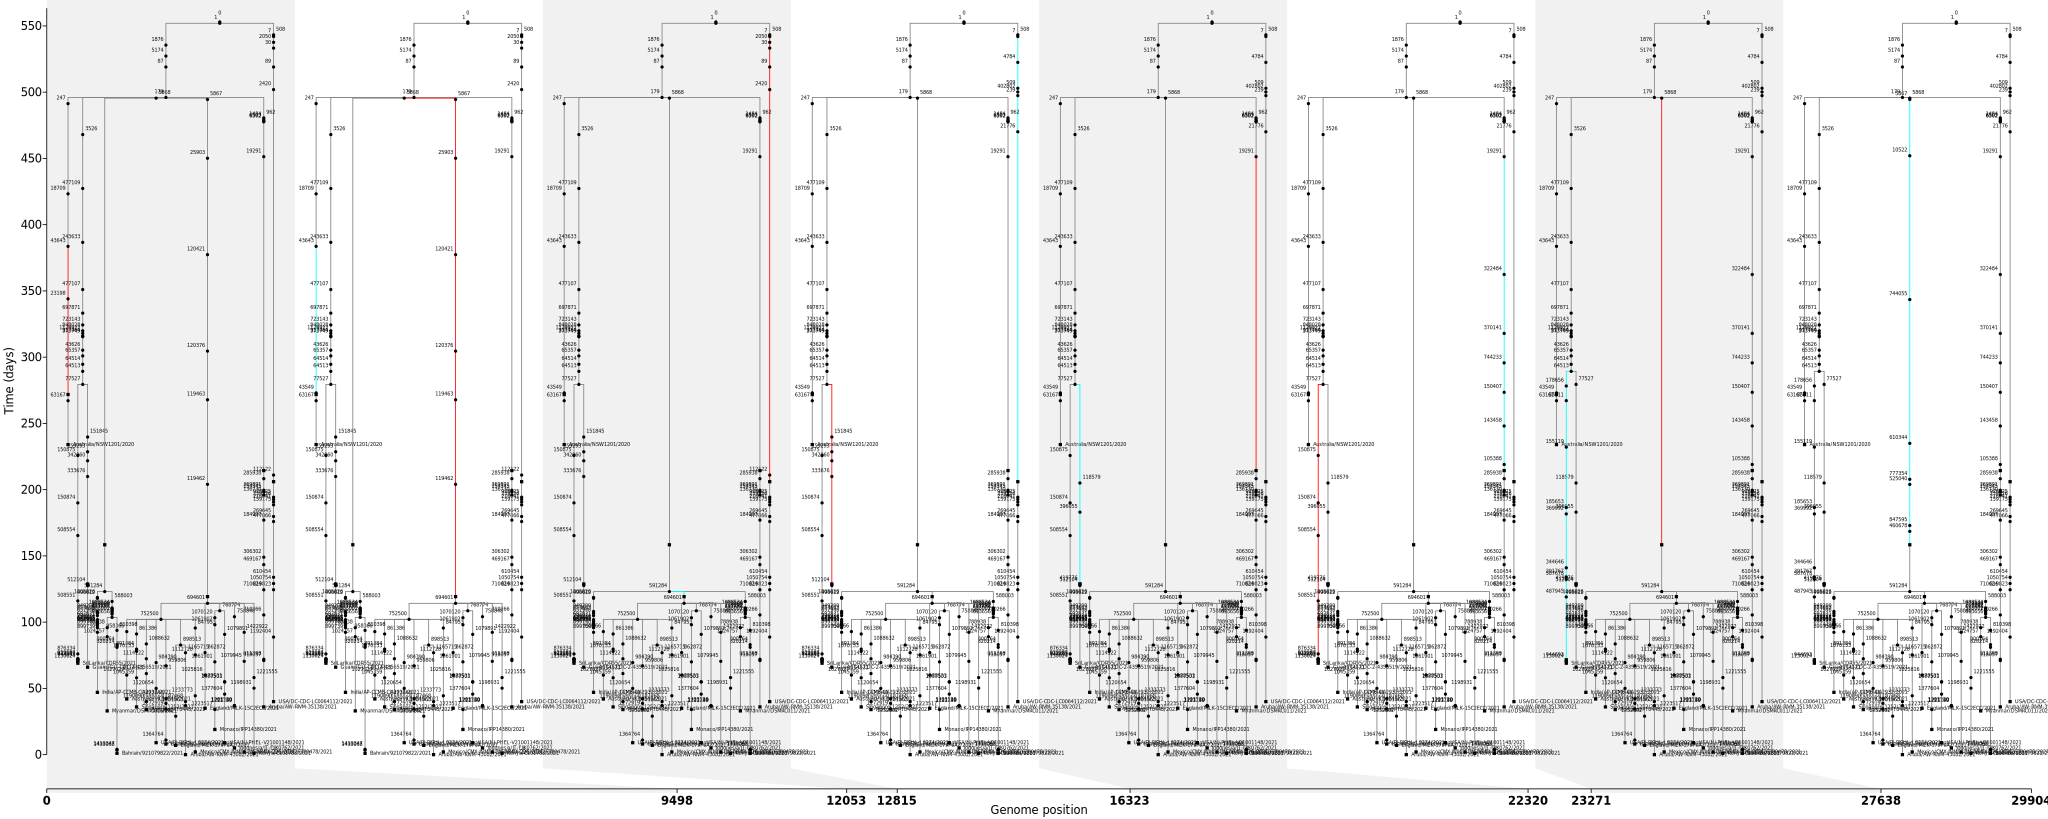

In [7]:
import collections

style = ".node .lab {font-size:6px} .leaf .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
style += ".edge {stroke: grey}"
e_out = collections.defaultdict(set)
e_in = collections.defaultdict(set)
for tree_id, ed in enumerate(simp.edge_diffs()):
    if ed.interval.left != 0:
        for i in ed.edges_in:
            e_in[tree_id].add((i.parent, i.child))
    for o in ed.edges_out:
        e_out[tree_id - 1].add((o.parent, o.child))
style += ''.join([
    f".t{tree} .a{c[0]}.n{c[1]} > .edge {{stroke: red}}"
    for tree, edges in e_out.items()
    for c in edges])
style += ''.join([
    f".t{tree} .a{c[0]}.n{c[1]} > .edge {{stroke: cyan}}"
    for tree, edges in e_in.items()
    for c in edges])

shown_nodes = {u for tree in simp.trees() for u in tree.nodes()}
node_labels = {u: (simp.node(u).metadata.get("strain", "") if simp.node(u).is_sample() else u) for u in shown_nodes}
simp.draw_svg(
    size=(2500, 1000),
    style=style,
    y_axis=True,
    symbol_size=4,
    y_ticks = np.arange(0, 600, 50),
    omit_sites=True,
    node_labels=node_labels
)

694601 is the obvious clonal MRCA here to collapse

In [8]:
# Check clonal
s = set(u for u in simp.first().samples(694601))
for tree in simp.trees():
    assert s == set(u for u in tree.samples(694601))

style += (
    # Hide all nodes descending from node 4. We then treat node 4 as a summary node
    ".n694601 > .node {display: none}"
    
    # Use clipping & scaling to change the symbol for node 4 into a summary triangle
    ".n694601 > .sym {clip-path: polygon(50% 50%, 75% 75%, 25% 75%); transform: scale(8.0, 8.0)}"
    
    # Make the font bigger for this summary node label
    ".n694601 > .lab {transform: rotate(90deg) translate(100px); font-size: 16px}"
)
node_labels[694601] = f"{len(s)} samples"


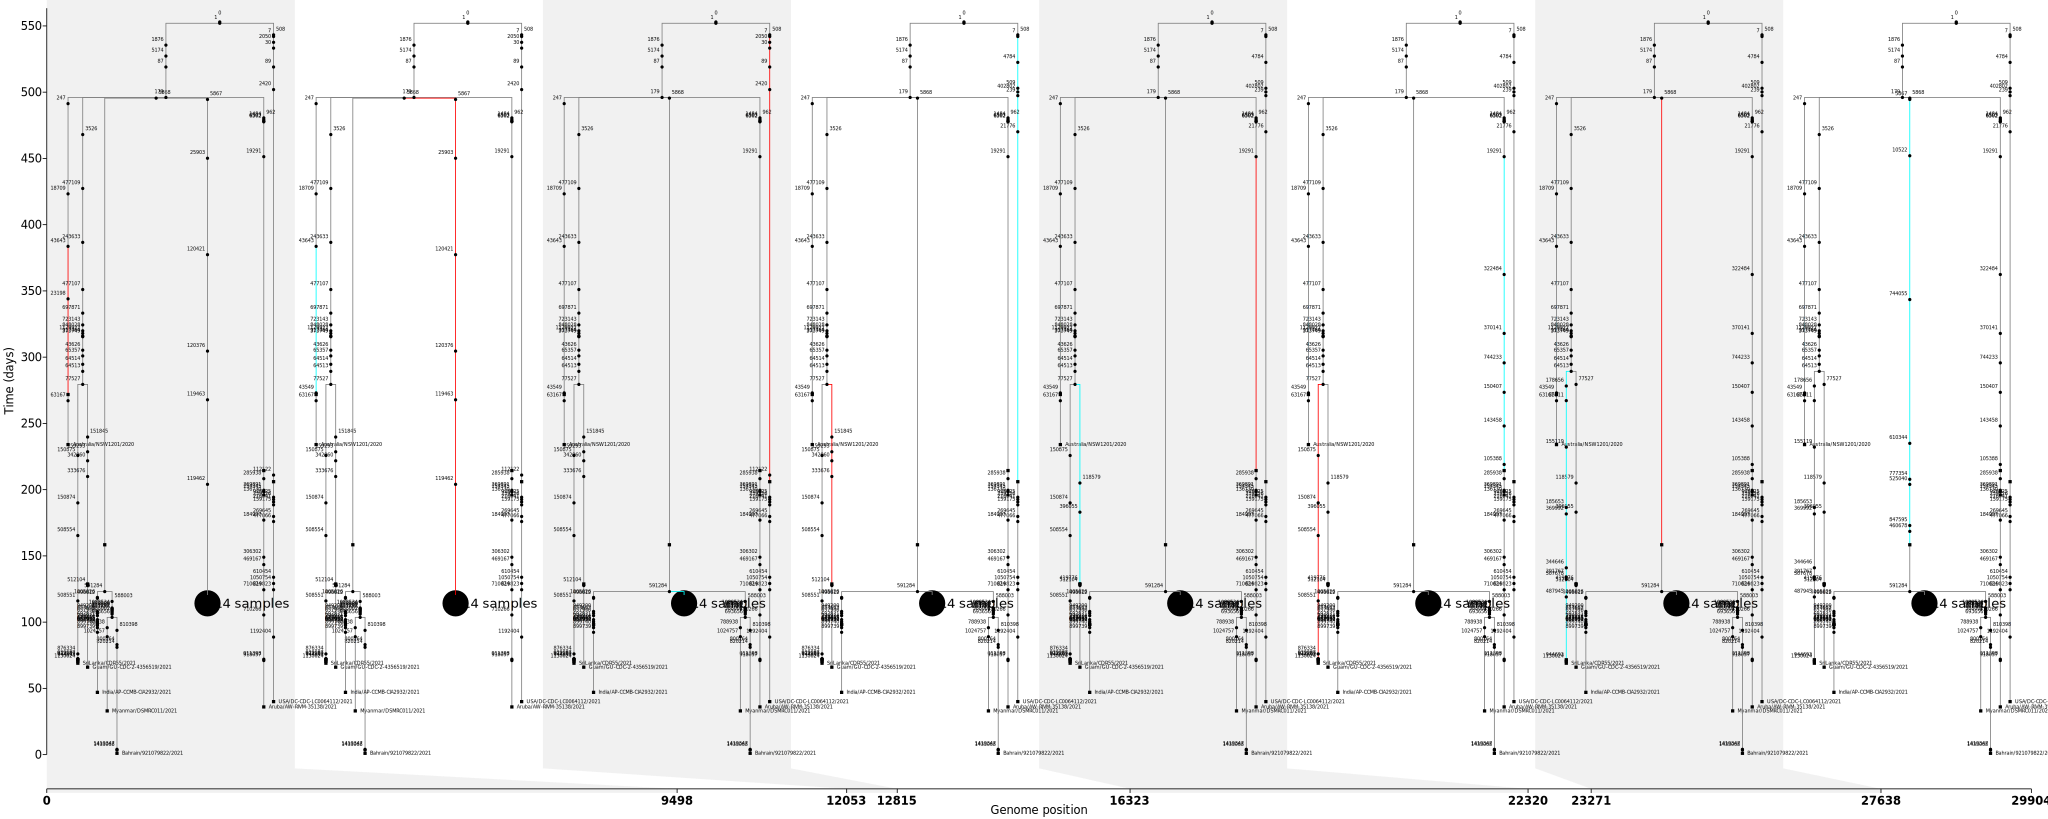

In [9]:
simp.draw_svg(
    size=(2500, 1000),
    style=style,
    y_axis=True,
    symbol_size=4,
    y_ticks = np.arange(0, 600, 50),
    omit_sites=True,
    node_labels=node_labels
)